## NLP for Task Classification

**Hypothesis**: Part of Speech (POS) tagging and syntactic dependency parsing provides valuable information for classifying imperative phrases. The thinking is that being able to detect imperative phrases will transfer well to detecting tasks and to-dos.

#### Some Terminology
- [_Imperative mood_](https://en.wikipedia.org/wiki/Imperative_mood) is "used principally for ordering, requesting or advising the listener to do (or not to do) something... also often used for giving instructions as to how to perform a task."
- _Part of speech (POS)_ is a way of categorizing a word based on its syntactic function.
    - The POS tagger from Spacy.io that is used in this notebook differentiates between [*pos_* and *tag_*](https://spacy.io/docs/api/annotation#pos-tagging-english) - *POS (pos_)* refers to "coarse-grained part-of-speech" like `VERB`, `ADJ`, or `PUNCT`; and *POSTAG (tag_)* refers to "fine-grained part-of-speech" like `VB`, `JJ`, or `.`.
- _Syntactic dependency parsing_ is a way of connecting words based on syntactic relationships, [such as](https://spacy.io/docs/api/annotation#dependency-parsing-english) `DOBJ` (direct object), `PREP` (prepositional modifier), or `POBJ` (object of preposition).
    - Check out the dependency parse of the phrase ["Send the report to Kyle by tomorrow"](https://demos.explosion.ai/displacy/?text=Send%20the%20report%20to%20Kyle%20by%20tomorrow&model=en&cpu=1&cph=1) as an example.

### Proposed Features
The imperative mood centers around _actions_, and actions are generally represented in English using verbs. So the features are engineered to also center on the VERB:
1. `FeatureName.VERB`: Does the phrase contain `VERB`(s) of the tag form `VB*`?
2. `FeatureName.FOLLOWING_POS`: Are the words following the `VERB`(s) of certain parts of speech?
3. `FeatureName.FOLLOWING_POSTAG`: Are the words following the `VERB`(s) of certain POS tags?
4. `FeatureName.CHILD_DEP`: Are the `VERB`(s) parents of certain syntactic dependencies?
5. `FeatureName.PARENT_DEP`: Are the `VERB`(s) children of certain syntactic dependencies?
6. `FeatureName.CHILD_POS`: Are the syntactic dependencies that the `VERB`(s) are children of of certain parts of speech?
7. `FeatureName.CHILD_POSTAG`: Are the syntactic dependencies that the `VERB`(s) are children of of certain POS tags?
8. `FeatureName.PARENT_POS`: Are the syntactic dependencies that the `VERB`(s) parent of certain parts of speech?
9. `FeatureName.PARENT_POSTAG`: Are the syntactic dependencies that the `VERB`(s) parent of certain POS tags?

**Notes:**
- Features 2-9 all depend on feature 1 between `True`; if `False`, phrase vectorization will result in all zeroes.
- When features 2-9 are applied to actual phrases, they will append identifying informating about the feature in the form of `_*` (e.g., `FeatureName.FOLLOWING_POSTAG_WRB`).

## Data and Setup

### Building a recipe corpus

I wrote and ran `epicurious_recipes.py`\* to scrape Epicurious.com for recipe instructions and descriptions. I then performed some manual cleanup of the script results. Output is in `epicurious-pos.txt` and `epicurious-neg.txt`.

\* _script (very) loosely based off of https://github.com/benosment/hrecipe-parse_

**Note** that deriving all negative examples in the training set from Epicurious recipe descriptions would result in negative examples that are longer and syntactically more complicated than the positive examples. This is a form of bias.

To (hopefully?) correct for this a bit, I will add the short movie reviews found at https://pythonprogramming.net/static/downloads/short_reviews/ as more negative examples.

This still feels weird because we're selecting negative examples only from specific categories of text (recipe descriptions, short movie reviews) - just because they're readily available. Further, most positive examples are recipe instructions - also a specific (and not necessarily related to the main "task" category) category of text.

Ultimately though, this recipe corpus is a **stopgap/proof of concept** for a corpus more relevant to tasks later on, so I won't worry further about this for now.

In [1]:
import os
from pandas import read_csv
from numpy import random

In [2]:
BASE_DIR = os.getcwd()
data_path = BASE_DIR + '/data.tsv'

In [3]:
df = read_csv(data_path, sep='\t', header=None, names=['Text', 'Label'])
df.head()

,Text,Label
0,Be kind,pos
1,Get out of here,pos
2,Look this over,pos
3,"Paul, do your homework now",pos
4,Do not clean soot off the window,pos


In [4]:
pos_data_split = list(df.loc[df.Label == 'pos'].Text)
neg_data_split = list(df.loc[df.Label == 'neg'].Text)

num_pos = len(pos_data_split)
num_neg = len(neg_data_split)

# 50/50 split between the number of positive and negative samples
num_per_class = num_pos if num_pos < num_neg else num_neg

# shuffle samples
random.shuffle(pos_data_split)
random.shuffle(neg_data_split)

In [5]:
lines = []
for l in pos_data_split[:num_per_class]:
    lines.append((l, 'pos'))
for l in neg_data_split[:num_per_class]:
    lines.append((l, 'neg'))

In [6]:
# Features as defined in the introduction
from enum import Enum, auto
class FeatureName(Enum):
    VERB = auto()
    FOLLOWING_POS = auto()
    FOLLOWING_POSTAG = auto()
    CHILD_DEP = auto()
    PARENT_DEP = auto()
    CHILD_POS = auto()
    CHILD_POSTAG = auto()
    PARENT_POS = auto()
    PARENT_POSTAG = auto()

## [spaCy.io](https://spacy.io/) for NLP
_Because Stanford CoreNLP is hard to install for Python_

Found Spacy through an article on ["Training a Classifier for Relation Extraction from Medical Literature"](https://www.microsoft.com/developerblog/2016/09/13/training-a-classifier-for-relation-extraction-from-medical-literature/) ([GitHub](https://github.com/CatalystCode/corpus-to-graph-ml))

<img src="nltk_library_comparison.png" alt="NLTK library comparison chart https://spacy.io/docs/api/#comparison" style="width: 400px; margin: 0;"/>

In [7]:
#!conda config --add channels conda-forge
#!conda install spacy
#!python -m spacy download en

### Using the Spacy Data Model for NLP

In [8]:
import spacy
# slow
nlp = spacy.load('en')

Spacy's sentence segmentation is lacking... https://github.com/explosion/spaCy/issues/235. So each '\n' will start a new Spacy Doc.

In [9]:
def create_spacy_docs(ll):
    dd = [(nlp(l[0]), l[1]) for l in ll]
    # collapse noun phrases into single compounds
    for d in dd:
        for np in d[0].noun_chunks:
            np.merge(np.root.tag_, np.text, np.root.ent_type_)
    return dd

In [10]:
# slower
docs = create_spacy_docs(lines)

### NLP output

Tokenization, POS tagging, and dependency parsing happened automatically with the `nlp(line)` calls above! So let's look at the outputs.

https://spacy.io/docs/usage/data-model and https://spacy.io/docs/api/doc will be useful going forward

In [11]:
for doc in docs[:10]:
    print(list(doc[0].sents))

[Transfer gazpacho to an airtight container; cover and chill until very cold, 4–12 hours.]
[Add jalapeño and salt and toss to combine.]
[Transfer to a paper-towel lined plate.]
[Season pork chops all over with salt and pepper; sprinkle with aniseed and red pepper flakes.]
[Lightly season with salt and pepper and drizzle vinaigrette over; top with walnuts and mint.]
[Slice in half diagonally and serve.]
[Lower the heat to 200°F and bake for 2 to 3 more hours, until the skin is a dark caramel brown and the top is no longer moist or sticky.]
[You could also do this on a floured surface, but the pastry is so fragile I find it easier to handle between cling film.]
[Prepare a grill for medium-high heat or heat a grill pan or cast-iron skillet over medium-high; oil grate or pan.]
[Serve or freeze in an airtight container for up to a week.]


In [12]:
for doc in docs[:10]:
    print(list(doc[0].noun_chunks))

[Transfer gazpacho, an airtight container, cover, chill, 4–12 hours]
[jalapeño, salt]
[Transfer, a paper-towel lined plate]
[Season pork, salt, pepper, aniseed, red pepper flakes]
[Lightly season, salt, pepper, drizzle vinaigrette, walnuts, mint]
[Slice, half]
[the heat, bake, 2 to 3 more hours, the skin, a dark caramel brown, the top]
[You, a floured surface, the pastry, I, it, film]
[a grill, medium-high heat or heat a grill pan, cast-iron skillet, medium, oil grate, pan]
[Serve, freeze, an airtight container]


[Spacy's dependency graph visualization](https://demos.explosion.ai/displacy)

In [13]:
for doc in docs[:5]:
    for token in doc[0]:
        print(token.text, token.dep_, token.lemma_, token.pos_, token.tag_, token.head, list(token.children))

Transfer gazpacho ROOT Transfer gazpacho NOUN NN Transfer gazpacho [to, .]
to prep to ADP IN Transfer gazpacho [an airtight container]
an airtight container pobj an airtight container NOUN NN to [;, cover, until]
; punct ; PUNCT : an airtight container []
cover conj cover NOUN NN an airtight container [and, chill]
and cc and CCONJ CC cover []
chill conj chill NOUN NN cover []
until prep until ADP IN an airtight container [cold, 4–12 hours]
very advmod very ADV RB cold []
cold pobj cold ADJ JJ until [very, ,]
, punct , PUNCT , cold []
4–12 hours pobj 4–12 hours NOUN NNS until []
. punct . PUNCT . Transfer gazpacho []
Add ROOT add VERB VB Add [jalapeño, toss, .]
jalapeño dobj jalapeño NOUN NN Add [and, salt]
and cc and CCONJ CC jalapeño []
salt conj salt NOUN NN jalapeño [and]
and cc and CCONJ CC salt []
toss conj toss VERB VB Add [combine]
to aux to PART TO combine []
combine xcomp combine VERB VB toss [to]
. punct . PUNCT . Add []
Transfer ROOT Transfer NOUN NN Transfer [to, .]
to prep

### Featurization

In [14]:
import re
from collections import defaultdict

def featurize(d):
    s_features = defaultdict(int)
    for idx, token in enumerate(d):
        if re.match(r'VB.?', token.tag_) is not None: # note: not using token.pos == VERB because this also includes BES, HVS, MD tags 
            s_features[FeatureName.VERB.name] += 1
            # FOLLOWING_POS
            # FOLLOWING_POSTAG
            next_idx = idx + 1;
            if next_idx < len(d):
                s_features[f'{FeatureName.FOLLOWING_POS.name}_{d[next_idx].pos_}'] += 1
                s_features[f'{FeatureName.FOLLOWING_POSTAG.name}_{d[next_idx].tag_}'] += 1
            # PARENT_DEP
            # PARENT_POS
            # PARENT_POSTAG
            '''
            "Because the syntactic relations form a tree, every word has exactly one head.
            You can therefore iterate over the arcs in the tree by iterating over the words in the sentence."
            https://spacy.io/docs/usage/dependency-parse#navigating
            '''
            if (token.head is not token):
                s_features[f'{FeatureName.PARENT_DEP.name}_{token.head.dep_.upper()}'] += 1
                s_features[f'{FeatureName.PARENT_POS.name}_{token.head.pos_}'] += 1
                s_features[f'{FeatureName.PARENT_POSTAG.name}_{token.head.tag_}'] += 1
            # CHILD_DEP
            # CHILD_POS
            # CHILD_POSTAG
            for child in token.children:
                s_features[f'{FeatureName.CHILD_DEP.name}_{child.dep_.upper()}'] += 1
                s_features[f'{FeatureName.CHILD_POS.name}_{child.pos_}'] += 1
                s_features[f'{FeatureName.CHILD_POSTAG.name}_{child.tag_}'] += 1
    return dict(s_features)

In [15]:
featuresets = [(doc[0], (featurize(doc[0]), doc[1])) for doc in docs]

In [16]:
from statistics import mean, median, mode, stdev
f_lengths = [len(fs[1][0]) for fs in featuresets]

print('Stats on number of features per example:')
print(f'mean: {mean(f_lengths)}')
print(f'stdev: {stdev(f_lengths)}')
print(f'median: {median(f_lengths)}')
print(f'mode: {mode(f_lengths)}')
print(f'max: {max(f_lengths)}')
print(f'min: {min(f_lengths)}')

Stats on number of features per example:
mean: 22.786088094199737
stdev: 14.556752789753176
median: 22.0
mode: 0
max: 75
min: 0


In [17]:
featuresets[:2]

[(Transfer gazpacho to an airtight container; cover and chill until very cold, 4–12 hours.,
  ({}, 'pos')),
 (Add jalapeño and salt and toss to combine.,
  ({'CHILD_DEP_AUX': 1,
    'CHILD_DEP_CONJ': 1,
    'CHILD_DEP_DOBJ': 1,
    'CHILD_DEP_PUNCT': 1,
    'CHILD_DEP_XCOMP': 1,
    'CHILD_POSTAG_.': 1,
    'CHILD_POSTAG_NN': 1,
    'CHILD_POSTAG_TO': 1,
    'CHILD_POSTAG_VB': 2,
    'CHILD_POS_NOUN': 1,
    'CHILD_POS_PART': 1,
    'CHILD_POS_PUNCT': 1,
    'CHILD_POS_VERB': 2,
    'FOLLOWING_POSTAG_.': 1,
    'FOLLOWING_POSTAG_NN': 1,
    'FOLLOWING_POSTAG_TO': 1,
    'FOLLOWING_POS_NOUN': 1,
    'FOLLOWING_POS_PART': 1,
    'FOLLOWING_POS_PUNCT': 1,
    'PARENT_DEP_CONJ': 1,
    'PARENT_DEP_ROOT': 1,
    'PARENT_POSTAG_VB': 2,
    'PARENT_POS_VERB': 2,
    'VERB': 3},
   'pos'))]

On one run, the above line printed the following featureset:
`(Gather foil loosely on top and bake for 1 1/2 hours., ({}, 'pos'))`

This is because the Spacy.io POS tagger provided this:
   `Gather/NNP foil/NN loosely/RB on/IN top/NN and/CC bake/NN for/IN 1 1/2 hours./NNS`

...with no VERBs tagged, which is incorrect.

"Voting - POS taggers and classifiers" in the _Next Steps/Improvements_ section below is meant to improve on this.

---
Compare to [Stanford CoreNLP POS tagger](http://nlp.stanford.edu:8080/corenlp/process):
   `Gather/VB foil/NN loosely/RB on/IN top/JJ and/CC bake/VB for/IN 1 1/2/CD hours/NNS ./.`

And [Stanford Parser](http://nlp.stanford.edu:8080/parser/index.jsp):
   `Gather/NNP foil/VB loosely/RB on/IN top/NN and/CC bake/VB for/IN 1 1/2/CD hours/NNS ./.`

### Classification

In [18]:
random.shuffle(featuresets)

num_classes = 2
split_num = round(num_per_class*num_classes / 5)

# train and test sets
testing_set = [fs[1] for i, fs in enumerate(featuresets[:split_num])]
training_set =  [fs[1] for i, fs in enumerate(featuresets[split_num:])]

print(f'# training samples: {len(training_set)}')
print(f'# test samples: {len(testing_set)}')

# training samples: 3669
# test samples: 917


In [19]:
# decoupling the functionality of nltk.classify.accuracy
def predict(classifier, gold, prob=True):
    if (prob is True):
        predictions = classifier.prob_classify_many([fs for (fs, ll) in gold])
    else:
        predictions = classifier.classify_many([fs for (fs, ll) in gold])
    return list(zip(predictions, [ll for (fs, ll) in gold]))

def accuracy(predicts, prob=True):
    if (prob is True):
        correct = [label == prediction.max() for (prediction, label) in predicts]
    else:
        correct = [label == prediction for (prediction, label) in predicts]
        
    if correct:
        return sum(correct) / len(correct)
    else:
        return 0

Note below the use of `DummyClassifier` to provide a simple sanity check, a baseline of random predictions. `stratified` means it "generates random predictions by respecting the training set class distribution." (http://scikit-learn.org/stable/modules/model_evaluation.html#dummy-estimators)

> More generally, when the accuracy of a classifier is too close to random, it probably means that something went wrong: features are not helpful, a hyperparameter is not correctly tuned, the classifier is suffering from class imbalance, etc…

If a classifier can beat the `DummyClassifier`, it is at least learning something valuable! How valuable is another question...

In [20]:
from nltk import NaiveBayesClassifier
from nltk.classify.decisiontree import DecisionTreeClassifier
from nltk.classify.scikitlearn import SklearnClassifier

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegressionCV, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

dummy = SklearnClassifier(DummyClassifier(strategy='stratified', random_state=0))
dummy.train(training_set)
dummy_predict = predict(dummy, testing_set)
dummy_accuracy = accuracy(dummy_predict)
print("Dummy classifier accuracy percent:", dummy_accuracy*100)

nb = NaiveBayesClassifier.train(training_set)
nb_predict = predict(nb, testing_set)
nb_accuracy = accuracy(nb_predict)
print("NaiveBayes classifier accuracy percent:", nb_accuracy*100)

multinomial_nb = SklearnClassifier(MultinomialNB())
multinomial_nb.train(training_set)
mnb_predict = predict(multinomial_nb, testing_set)
mnb_accuracy = accuracy(mnb_predict)
print("MultinomialNB classifier accuracy percent:", mnb_accuracy*100)

bernoulli_nb = SklearnClassifier(BernoulliNB())
bernoulli_nb.train(training_set)
bnb_predict = predict(bernoulli_nb, testing_set)
bnb_accuracy = accuracy(bnb_predict)
print("BernoulliNB classifier accuracy percent:", bnb_accuracy*100)

# ??logistic_regression._clf
#   sklearn.svm.LinearSVC : learns SVM models using the same algorithm.
logistic_regression = SklearnClassifier(LogisticRegressionCV())
logistic_regression.train(training_set)
lr_predict = predict(logistic_regression, testing_set)
lr_accuracy = accuracy(lr_predict)
print("LogisticRegressionCV classifier accuracy percent:", lr_accuracy*100)

# ??sgd._clf
#    The 'log' loss gives logistic regression, a probabilistic classifier.
# ??linear_svc._clf
#   can optimize the same cost function as LinearSVC
#   by adjusting the penalty and loss parameters. In addition it requires
#   less memory, allows incremental (online) learning, and implements
#   various loss functions and regularization regimes.
sgd = SklearnClassifier(SGDClassifier(loss='log'))
sgd.train(training_set)
sgd_predict = predict(sgd, testing_set)
sgd_accuracy = accuracy(sgd_predict)
print("SGD classifier accuracy percent:", sgd_accuracy*100)

# slow
# using libsvm with kernel 'rbf' (radial basis function)
svc = SklearnClassifier(SVC(probability=True))
svc.train(training_set)
svc_predict = predict(svc, testing_set)
svc_accuracy = accuracy(svc_predict)
print("SVC classifier accuracy percent:", svc_accuracy*100)

# ??linear_svc._clf
#    Similar to SVC with parameter kernel='linear', but implemented in terms of
#    liblinear rather than libsvm, so it has more flexibility in the choice of
#    penalties and loss functions and should scale better to large numbers of
#    samples.
#    Prefer dual=False when n_samples > n_features.
# Using CalibratedClassifierCV as wrapper to get predict probabilities (https://stackoverflow.com/a/39712590)
linear_svc = SklearnClassifier(CalibratedClassifierCV(LinearSVC(dual=False)))
linear_svc.train(training_set)
linear_svc_predict = predict(linear_svc, testing_set)
linear_svc_accuracy = accuracy(linear_svc_predict)
print("LinearSVC classifier accuracy percent:", linear_svc_accuracy*100)

# slower
dt = DecisionTreeClassifier.train(training_set)
dt_predict = predict(dt, testing_set, False)
dt_accuracy = accuracy(dt_predict, False)
print("DecisionTree classifier accuracy percent:", dt_accuracy*100)

random_forest = SklearnClassifier(RandomForestClassifier(n_estimators = 100))
random_forest.train(training_set)
rf_predict = predict(random_forest, testing_set)
rf_accuracy = accuracy(rf_predict)
print("RandomForest classifier accuracy percent:", rf_accuracy*100)

Dummy classifier accuracy percent: 48.74591057797165
NaiveBayes classifier accuracy percent: 68.04798255179935
MultinomialNB classifier accuracy percent: 80.26172300981462
BernoulliNB classifier accuracy percent: 74.2639040348964
LogisticRegressionCV classifier accuracy percent: 84.07851690294439
SGD classifier accuracy percent: 56.706652126499456
SVC classifier accuracy percent: 83.09705561613958
LinearSVC classifier accuracy percent: 83.86041439476554
DecisionTree classifier accuracy percent: 78.29880043620501
RandomForest classifier accuracy percent: 83.6423118865867


### SGD: Multiple Epochs

`sgd` classifiers improves with epochs. `??sgd._clf` tells us that the default number of epochs `n_iter` is 5. So let's run more epochs. Also not that the training_set shuffle is `True` by default.

In [21]:
num_epochs = 1000
sgd = SklearnClassifier(SGDClassifier(loss='log', n_iter=num_epochs))
sgd.train(training_set)
sgd_predict = predict(sgd, testing_set)
sgd_accuracy = accuracy(sgd_predict)
print(f"SGDClassifier classifier accuracy percent (epochs: {num_epochs}):", sgd_accuracy*100)

SGDClassifier classifier accuracy percent (epochs: 1000): 84.18756815703381


Fortunately, 1000 epochs run very quickly! And `SGDClassifier` performance has improved with more iterations.

*Also note that we can set `warm_start` to `True` if we want to take advantage of online learning and reuse the solution of the previous call.*

### GridSearch and Cross-Validation

Next we perform 1) grid search to find optimal hyperparameters, and 2) cross-validation to evaluate performance over multiple folds of the data (to avoid overfitting).

http://scikit-learn.org/stable/modules/grid_search.html#grid-search

http://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html

In [22]:
from nltk.classify.scikitlearn import SklearnClassifier

from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

In [23]:
# https://stackoverflow.com/a/16388804
from sklearn.model_selection import KFold
from sklearn.base import clone
from numpy import zeros

def cross_val(name, model, debug=True):
    num_splits = 3
    original_clf = clone(model._clf)
    cvidx = KFold(n_splits=num_splits, shuffle=True).split(training_set)
    
    nested_acc = zeros(num_splits)
    i=0
    for trainidx, testidx in cvidx:
        model._clf = clone(original_clf)  # we clone the estimator to make sure that all the folds are independent
        classifier = model.train(training_set[trainidx[0]:trainidx[len(trainidx)-1]])
        pred = predict(classifier, training_set[testidx[0]:testidx[len(testidx)-1]])
        nested_acc[i] = accuracy(pred)
        i += 1
    
    if debug == True:
        print(f"{name} CV accuracies:", nested_acc)
    
    return nested_acc.mean()

In [24]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Set the parameters by cross-validation
model_parameters = [{'LinearSVC': [{
                        'loss': ['hinge'],
                        'dual': [True],
                        'penalty': ['l2'],
                        'tol': [1e-3, 1e-4, 1e-5],
                        'max_iter': [1000, 10000],
                        'C': [100.0, 1.0, 0.01]
                    },
                    {
                        'loss': ['squared_hinge'],
                        'dual': [False, True],
                        'penalty': ['l2'],
                        'tol': [1e-3, 1e-4, 1e-5],
                        'max_iter': [1000, 10000],
                        'C': [100.0, 1.0, 0.01]
                    }]},
                   {'LogisticRegression': [{
                        'penalty': ['l1'],
                        'dual': [False],
                        'C': [100.0, 1.0, 0.01],
                        'solver': ['liblinear']
                   },
                   {
                        'penalty': ['l2'],
                        'dual': [False, True],
                        'C': [100.0, 1.0, 0.01],
                        'max_iter': [100, 1000],
                        'solver': ['liblinear'],
                        'tol': [1e-3, 1e-4, 1e-5]
                   },
                   {
                        'penalty': ['l2'],
                        'dual': [False],
                        'C': [100.0, 1.0, 0.01],
                        'max_iter': [100, 1000],
                        'solver': ['newton-cg', 'lbfgs', 'sag'],
                        'tol': [1e-3, 1e-4, 1e-5]
                   }]},
                   {'SGD': [{
                        'penalty': ['l1', 'l2', 'elasticnet'],
                        'alpha': [1e-3, 1e-4, 1e-5],
                        'average': [True, False],
                        'n_iter': [100, 1000, 10000]
                   }]},
                   {'RandomForest': [{
                        'n_estimators': [10, 100, 1000],
                        'criterion': ['gini', 'entropy'],
                        'max_features': ['auto', 'log2', None],
                        'oob_score': [True, False]
                   }]}]

score = 'roc_auc'

for i, model_param in enumerate(model_parameters):
    model = [key for i, key in enumerate(model_param)][0]
    
    print(f"# {model}: Tuning hyper-parameters for {score}")
    print()
    
    if model == 'LinearSVC': 
        clf = LinearSVC()
    elif model == 'LogisticRegression':
        clf = LogisticRegression()
    elif model == 'SGD':
        clf = SGDClassifier(loss='log')
    elif model == 'RandomForest':
        clf = RandomForestClassifier()
    else:
        raise Exception('%s model needs to be added to the if-block' % model)

    grid = SklearnClassifier(GridSearchCV(clf, model_param[model], cv=5,
                       scoring=score, n_jobs=-1))
    grid.train(training_set)

    print("Best parameters set found on development set:")
    print()
    print(grid._clf.best_params_)
    mean = grid._clf.cv_results_['mean_test_score'][grid._clf.best_index_]
    std = grid._clf.cv_results_['std_test_score'][grid._clf.best_index_]
    print("roc_auc: %0.3f (+/-%0.03f)" % (mean, std * 2))
    print()
    
    if model == 'LinearSVC':
        # Wrapping LinearSVC in CalibratedClassifierCV to add support for probability prediction
        # Note that there is a difference in accuracies between raw GridSearchCV and calibrated GridSearchCV
        # However, I'm willing to sacrifice the potential 'best' result from raw in order to output probabilities
        grid_calibrated = SklearnClassifier(CalibratedClassifierCV(grid._clf.best_estimator_, cv=None))
        grid_calibrated.train(training_set)
        gridc_predict = predict(grid_calibrated, testing_set)
        gridc_accuracy = accuracy(gridc_predict)
        print(f"{model} (calibrated) classifier accuracy percent:", gridc_accuracy*100)
        
        grid_predict = predict(grid, testing_set, False)
        grid_accuracy = accuracy(grid_predict, False)
        print(f"{model} (raw) classifier accuracy percent:", grid_accuracy*100)
        
        # CV after parameter optimization
        cv_acc = cross_val(model, grid_calibrated)
        print(f"{model} (calibrated) CV classifier avg accuracy percent:", cv_acc*100)
        
        linear_svc_opt = grid_calibrated
        linear_svc_predict = gridc_predict
    else:
        grid_predict = predict(grid, testing_set)
        grid_accuracy = accuracy(grid_predict)
        print(f"{model} classifier accuracy percent:", grid_accuracy*100)
        
        # CV after parameter optimization
        cv_acc = cross_val(model, grid)
        print(f"{model} CV classifier avg accuracy percent:", cv_acc*100)
        
        if model == 'LogisticRegression':
            logistic_regression_opt = grid
            lr_predict = grid_predict
        elif model == 'SGD':
            sgd_opt = grid
            sgd_predict = grid_predict
        elif model == 'RandomForest':
            random_forest_opt = grid
            rf_predict = grid_predict
        else:
            raise Exception('%s model was not run through Grid Search' % model)
    
    print()

# LinearSVC: Tuning hyper-parameters for roc_auc

Best parameters set found on development set:

{'C': 0.01, 'dual': False, 'loss': 'squared_hinge', 'max_iter': 1000, 'penalty': 'l2', 'tol': 0.001}
roc_auc: 0.908 (+/-0.018)

LinearSVC (calibrated) classifier accuracy percent: 83.42420937840785
LinearSVC (raw) classifier accuracy percent: 83.53326063249727
LinearSVC CV accuracies: [ 0.83387889  0.83383438  0.83396947]
LinearSVC (calibrated) CV classifier avg accuracy percent: 83.3894244566

# LogisticRegression: Tuning hyper-parameters for roc_auc

Best parameters set found on development set:

{'C': 1.0, 'dual': True, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}
roc_auc: 0.908 (+/-0.016)

LogisticRegression classifier accuracy percent: 84.18756815703381
LogisticRegression CV accuracies: [ 0.837241    0.83701884  0.83670678]
LogisticRegression CV classifier avg accuracy percent: 83.6988874553

# SGD: Tuning hyper-parameters for roc_auc

Best parameters set fou

### VotingClassifier

We're going to create an ensemble classifier by letting our top-performing classifiers, which consistently perform with >80% accuracy &mdash; `LogisticRegression`, `LinearSVC`, `SGD`, and `RandomForest` (excluding `SVC` due to its slowness) &mdash; vote on each prediction.

In [34]:
from sklearn.ensemble import VotingClassifier

voting = SklearnClassifier(VotingClassifier(estimators=[
    ('lr', logistic_regression_opt._clf),
    ('linear_svc', linear_svc_opt._clf),
    ('sgd', sgd_opt._clf),
    ('rf', random_forest_opt._clf)
], voting='soft', weights=[1,1,1,3], n_jobs=-1))
voting.train(training_set)

voting_predict = predict(voting, testing_set)
voting_accuracy = accuracy(voting_predict)
print("Soft voting classifier accuracy percent:", voting_accuracy*100)

# CV after parameter optimization
voting_acc = cross_val("Soft voting", voting)
print(f"Soft voting CV classifier accuracy percent:", voting_acc*100)

Soft voting classifier accuracy percent: 84.29661941112323
Soft voting CV accuracies: [ 0.89822647  0.898527    0.89559989]
Soft voting CV classifier accuracy percent: 89.7451120722


### Analysis

Similarly to the voting model, we're also going to scope analysis down to our top-performing classifiers. We'll include the `Voting` model itself, and then `Dummy` as a baseline.

#### Most Informative Features

In [28]:
# https://stackoverflow.com/a/11140887
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:round(n/2)], coefs_with_fns[:-(round(n/2) + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [29]:
print('SGD')
show_most_informative_features(sgd._vectorizer, sgd._clf, 15)
print()
print('Logistic Regression')
show_most_informative_features(logistic_regression._vectorizer, logistic_regression._clf, 15)

SGD
	-2.5549	CHILD_DEP_AGENT		2.3775	PARENT_DEP_ADVMOD||CONJ
	-2.3709	CHILD_POSTAG_``		2.2319	CHILD_DEP_DOBJ||XCOMP
	-2.0919	PARENT_DEP_AMOD		2.1958	CHILD_POSTAG_-RRB-
	-1.8619	PARENT_POSTAG_VBZ		1.7032	CHILD_DEP_NPADVMOD
	-1.8443	CHILD_DEP_CSUBJ		1.6896	FOLLOWING_POSTAG_MD
	-1.8137	CHILD_POSTAG_HYPH		1.5639	PARENT_DEP_OPRD
	-1.7267	CHILD_DEP_INTJ 		1.5519	PARENT_POS_PROPN
	-1.6111	PARENT_POSTAG_CD		1.5519	PARENT_POSTAG_NNP

Logistic Regression
	-1.5202	CHILD_DEP_AGENT		1.2352	CHILD_DEP_NPADVMOD
	-1.4173	PARENT_POSTAG_VBZ		1.1783	CHILD_POSTAG_-RRB-
	-1.3431	CHILD_DEP_NSUBJ		1.0003	VERB           
	-1.1485	CHILD_POSTAG_HYPH		0.9728	PARENT_POS_PROPN
	-0.9715	CHILD_POS_ADJ  		0.9728	PARENT_POSTAG_NNP
	-0.9480	CHILD_DEP_ATTR 		0.9693	CHILD_DEP_MARK 
	-0.9114	CHILD_POSTAG_``		0.9398	PARENT_POSTAG_VB
	-0.8811	CHILD_DEP_CSUBJ		0.8721	CHILD_POSTAG_: 


*Note: Because `CalibratedClassifierCV` has no attribute `coef_`, we cannot show the most informative features for `LinearSVC` while it's wrapped. `Random Forest` and `Voting` also lack `coef_`.*

In [30]:
spacy.explain("JJS")

'adjective, superlative'

**Negative coefficients**:
- VERB parents [`AGENT`](http://universaldependencies.org/docs/sv/dep/nmod-agent.html): "used for agents of passive verbs" - interpreting this to mean that _existence of passive verbs (i.e., the opposite of active verbs) means negative correlation with it being imperative_
- VERB followed by a `WRB`: "wh-adverb" (where, when)
- VERB is a child of [`AMOD`](http://universaldependencies.org/en/dep/amod.html): "any adjective or adjectival phrase that serves to modify the meaning" of the verb


**Positive coefficients**:
- VERB parents a `-RRB-`: "right round bracket"
- VERB is a child of `PROPN`: "proper noun"
- VERB is a child of `NNP`: "noun, proper singular"

#### Scikit Learn metrics: Confusion matrix, Classification report, F1 score, Log loss

http://scikit-learn.org/stable/modules/model_evaluation.html

In [31]:
from sklearn import metrics

def classification_report(predict, prob=True):
    predictions, labels = zip(*predict)
    if prob is True:
        return metrics.classification_report(labels, [p.max() for p in predictions])
    else:
        return metrics.classification_report(labels, predictions)

def confusion_matrix(predict, prob=True, print_layout=False):
    predictions, labels = zip(*predict)
    if print_layout is True:
        print('Layout\n[[tn   fp]\n [fn   tp]]\n')
    if prob is True:
        return metrics.confusion_matrix(labels, [p.max() for p in predictions])
    else:
        return metrics.confusion_matrix(labels, predictions)
    
def log_loss(predict):
    predictions, labels = zip(*predict)
    return metrics.log_loss(labels, [p.prob('pos') for p in predictions])

def roc_auc_score(predict):
    predictions, labels = zip(*predict)
    # need to convert labels to binary classification of 0 or 1
    return metrics.roc_auc_score([1 if l == 'pos' else 0 for l in labels], [p.prob('pos') for p in predictions], average='weighted')

def precision_recall_curve(predict):
    predictions, labels = zip(*predict)
    return metrics.precision_recall_curve(labels, [p.prob('pos') for p in predictions], pos_label='pos')

def average_precision_score(predict):
    predictions, labels = zip(*predict)
    return metrics.average_precision_score([1 if l == 'pos' else 0 for l in labels], [p.prob('pos') for p in predictions])

def roc_curve(predict):
    predictions, labels = zip(*predict)
    return metrics.roc_curve(labels, [p.prob('pos') for p in predictions], pos_label='pos')

In [32]:
print('SGD')
print(classification_report(sgd_predict))
print()
print('Logistic Regression')
print(classification_report(lr_predict))
print()
print('LinearSVC')
print(classification_report(linear_svc_predict))
print()
print('Random Forest')
print(classification_report(rf_predict))

SGD
             precision    recall  f1-score   support

        neg       0.90      0.75      0.82       470
        pos       0.78      0.91      0.84       447

avg / total       0.84      0.83      0.83       917


Logistic Regression
             precision    recall  f1-score   support

        neg       0.89      0.79      0.84       470
        pos       0.80      0.89      0.85       447

avg / total       0.85      0.84      0.84       917


LinearSVC
             precision    recall  f1-score   support

        neg       0.88      0.78      0.83       470
        pos       0.80      0.89      0.84       447

avg / total       0.84      0.83      0.83       917


Random Forest
             precision    recall  f1-score   support

        neg       0.88      0.80      0.84       470
        pos       0.81      0.89      0.85       447

avg / total       0.85      0.84      0.84       917



In [35]:
print('Voting')
print(classification_report(voting_predict))

Voting
             precision    recall  f1-score   support

        neg       0.89      0.79      0.84       470
        pos       0.80      0.89      0.85       447

avg / total       0.85      0.84      0.84       917



In [36]:
print('Layout\n[[tn   fp]\n [fn   tp]]\n')

print('SGD')
print(confusion_matrix(sgd_predict))
print()
print('Logistic Regression')
print(confusion_matrix(lr_predict))
print()
print('LinearSVC')
print(confusion_matrix(linear_svc_predict))
print()
print('Random Forest')
print(confusion_matrix(rf_predict))

Layout
[[tn   fp]
 [fn   tp]]

SGD
[[353 117]
 [ 39 408]]

Logistic Regression
[[373  97]
 [ 48 399]]

LinearSVC
[[368 102]
 [ 50 397]]

Random Forest
[[377  93]
 [ 51 396]]


In [37]:
print('Voting')
print(confusion_matrix(voting_predict))

Voting
[[373  97]
 [ 47 400]]


The lower the better for `log_loss`...

In [38]:
print(f'SGD: {log_loss(sgd_predict)}')
print(f'Logistic Regression: {log_loss(lr_predict)}')
print(f'LinearSVC: {log_loss(linear_svc_predict)}')
print(f'Random Forest: {log_loss(rf_predict)}')

SGD: 0.36957712487581706
Logistic Regression: 0.3602890831167405
LinearSVC: 0.36916111074994923
Random Forest: 0.38073002357683455


In [39]:
print(f'Voting: {log_loss(voting_predict)}')

Voting: 0.3505806495460855


The higher the better for `roc_auc_score`...

In [40]:
print(f'SGD: {roc_auc_score(sgd_predict)}')
print(f'Logistic Regression: {roc_auc_score(lr_predict)}')
print(f'LinearSVC: {roc_auc_score(linear_svc_predict)}')
print(f'Random Forest: {roc_auc_score(rf_predict)}')

SGD: 0.9202865438621544
Logistic Regression: 0.9209814841258509
LinearSVC: 0.9181636441525061
Random Forest: 0.9228782902565567


In [41]:
print(f'Voting: {roc_auc_score(voting_predict)}')

Voting: 0.9323290018563473


#### Performance on sample tasks

In [43]:
sample_tasks = ["Mow lawn", "Mow the lawn", "Buy new shoes", "Feed the dog", "Send report to Kyle", "Send the report to Kyle", "Peel the potatoes"]
features = [featurize(nlp(task)) for task in sample_tasks]

tasks_dummy = [(l, p.prob('pos')*1.0) for l, p in zip(dummy.classify_many(features), dummy.prob_classify_many(features))]
tasks_logistic = [(l, p.prob('pos')) for l,p in zip(logistic_regression_opt.classify_many(features), logistic_regression_opt.prob_classify_many(features))]
tasks_linear_svc = [(l, p.prob('pos')) for l,p in zip(linear_svc_opt.classify_many(features), linear_svc_opt.prob_classify_many(features))]
tasks_sgd = [(l, p.prob('pos')) for l,p in zip(sgd_opt.classify_many(features), sgd_opt.prob_classify_many(features))]
tasks_rf = [(l, p.prob('pos')) for l,p in zip(random_forest_opt.classify_many(features), random_forest_opt.prob_classify_many(features))]
tasks_voting = [(l, p.prob('pos')) for l,p in zip(voting.classify_many(features), voting.prob_classify_many(features))]

print(f'Dummy: {tasks_dummy}')
print(f'LogisticRegression: {tasks_logistic}')
print(f'LinearSVC: {tasks_linear_svc}')
print(f'SGD: {tasks_sgd}')
print(f'Random Forest: {tasks_rf}')
print()
print(f'Voting: {tasks_voting}')

Dummy: [('neg', 0.0), ('neg', 0.0), ('neg', 0.0), ('neg', 0.0), ('pos', 1.0), ('neg', 0.0), ('pos', 1.0)]
LogisticRegression: [('pos', 0.57862802137868552), ('pos', 0.82713746377398456), ('pos', 0.94137130453808182), ('pos', 0.82713746377398456), ('pos', 0.72197606789783497), ('pos', 0.82713746377398456), ('pos', 0.84117203120422435)]
LinearSVC: [('pos', 0.62485948769521327), ('pos', 0.73801945489589904), ('pos', 0.8742231132727718), ('pos', 0.73801945489589904), ('pos', 0.70967647141483869), ('pos', 0.73801945489589904), ('pos', 0.76609305638857117)]
SGD: [('pos', 0.60621072131342246), ('pos', 0.80304033735548375), ('pos', 0.9300899085422456), ('pos', 0.80304033735548375), ('pos', 0.70050625854824256), ('pos', 0.80304033735548375), ('pos', 0.82347772218132842)]
Random Forest: [('pos', 0.52071951131625149), ('pos', 0.87285887236391291), ('pos', 0.74832988482365803), ('pos', 0.87285887236391291), ('pos', 0.80143704121964976), ('pos', 0.87285887236391291), ('pos', 0.84073885809507198)]



#### Voting Model: Curves

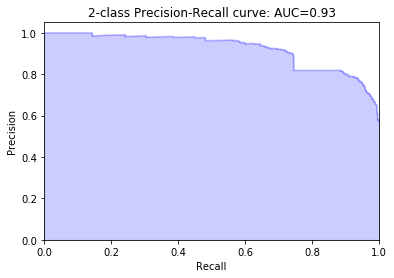

In [44]:
import matplotlib.pyplot as plt

precision, recall, prc_thresholds = precision_recall_curve(voting_predict)
average_precision = average_precision_score(voting_predict)

plt.figure()
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AUC={0:0.2f}'.format(
          average_precision))
plt.show()

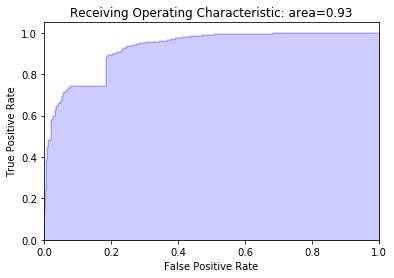

In [45]:
fpr, tpr, roc_thresholds = roc_curve(voting_predict)
area = roc_auc_score(voting_predict)

plt.figure()
plt.step(fpr, tpr, color='b', alpha=0.2,
         where='post')
plt.fill_between(fpr, tpr, step='post', alpha=0.2,
                 color='b')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Receiving Operating Characteristic: area={0:0.2f}'.format(
          area))
plt.show()

Considered a bad idea to actually adjust predictions based on optimal `Threshold` from holdout test data curves - it's a form of overfitting on the test set: https://stackoverflow.com/questions/32627926/scikit-changing-the-threshold-to-create-multiple-confusion-matrixes (although using ROC to do this might be ok? or on cross-validated training data? https://stackoverflow.com/a/35300649)

### Pickling the Voting Model

In [47]:
import pickle

print ("Exporting the voting model to model.pkl")
with open('model.pkl', 'wb') as f:
    pickle.dump(voting, f)

Exporting the voting model to model.pkl


In [48]:
# load the model back into memory
print("Importing the model from model.pkl")
with open('model.pkl', 'rb') as f:
    loaded_clf = pickle.load(f)

# predict on a new sample
task_new = 'Buy ice cream'
print ('New sample: {}'.format(task_new))

# score on the new sample
features = featurize(nlp(task_new));
predict = [(l, p.prob('pos')) for l,p in zip(loaded_clf.classify_many(features), loaded_clf.prob_classify_many(features))]
print('Predicted class is {}'.format(predict[0]))

Importing the model from model.pkl
New sample: Buy ice cream
Predicted class is ('pos', 0.90561978802951215)


## Next Steps and Improvements

1. Training set may be too specific/not relevant enough (recipe instructions for positive dataset, recipe descriptions+short movie reviews for negative dataset)
2. Throwing features into a blender - need to understand value of each
    - What feature "classes" tend to perform the best/worst?
    - [PCA](http://jotterbach.github.io/2016/03/24/Principal_Component_Analysis/): Reducing dimensionality using most informative feature information
3. Phrase vectorizations of all 0s - how problematic is this?
4. Varying feature vector lengths - does this matter?
5. Voting - POS taggers
    - [SciKit Learn: Ensembles](http://scikit-learn.org/stable/modules/ensemble.html)
    - [Kaggle Ensembling Guide](https://mlwave.com/kaggle-ensembling-guide/)
6. Combining verb phrases
7. Look at examples from different quadrants of the confusion matrix - is there something we can learn?
    - Same idea with the classification report

---
# Things abandoned

## NLTK

I needed a library that supports dependency parsing, which NLTK does not... so I thought I'd add the [Stanford CoreNLP](https://stanfordnlp.github.io/CoreNLP/) toolkit and [its associated software](https://nlp.stanford.edu/software/) to NLTK. However, there are many conflicting instructions for installing the Java-based project, depending on NLTK version used. By the time I figured this out, the installation had become a time sink. So I abandoned this effort in favor of Spacy.io.

I might return this way if I want to improve results/implement a voter system between the various linguistic and classification methods later.

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

### Tokenization

In [ ]:
sentences = [s for l in lines for s in sent_tokenize(l)] # punkt
sentences

In [ ]:
tagged_sentences = []
for s in sentences:
    words = word_tokenize(s)
    tagged = nltk.pos_tag(words) # averaged_perceptron_tagger
    tagged_sentences.append(tagged)
print(tagged_sentences)

#### Note: POS accuracy

`Run down to the shop, will you, Peter` is parsed unexpectedly by `nltk.pos_tag`:
> `[('Run', 'NNP'), ('down', 'RB'), ('to', 'TO'), ('the', 'DT'), ('shop', 'NN'), (',', ','), ('will', 'MD'), ('you', 'PRP'), (',', ','), ('Peter', 'NNP')]`

`Run` is tagged as a `NNP (proper noun, singular)`

I expected an output more like what the [Stanford Parser](http://nlp.stanford.edu:8080/parser/) provides:
> `Run/VBG down/RP to/TO the/DT shop/NN ,/, will/MD you/PRP ,/, Peter/NNP`

`Run` is tagged as a `VGB (verb, gerund/present participle)` - still not quite the `VB` I want, but at least it's a `V*`

_MEANWHILE..._

`nltk.pos_tag` did better with:
> `[('Do', 'VB'), ('not', 'RB'), ('clean', 'VB'), ('soot', 'NN'), ('off', 'IN'), ('the', 'DT'), ('window', 'NN')]`

Compared to [Stanford CoreNLP](http://nlp.stanford.edu:8080/corenlp/process) (note that this is different than what [Stanford Parser](http://nlp.stanford.edu:8080/parser/) outputs):
> `(ROOT (S (VP (VB Do) (NP (RB not) (JJ clean) (NN soot)) (PP (IN off) (NP (DT the) (NN window))))))`

Concern: _clean_ as `VB (verb, base form)` vs `JJ (adjective)` 

**IMPROVE** POS taggers should vote: nltk.pos_tag (averaged_perceptron_tagger), Stanford Parser, CoreNLP, etc.

Note what Spacy POS tagger did with `Run down to the shop, will you Peter`:

`Run/VB down/RP to/IN the shop/NN ,/, will/MD you/PRP ,/, Peter/NNP`

    where `Run` is the `VB` I expected from POS tagging (compared to `nltk.pos_tag` result of `NNP`). Also note that Spacy collapses `the shop` into a single unit, which should be helpful during featurization.

### Featurization

In [ ]:
import re
from collections import defaultdict

featuresets = []
for ts in tagged_sentences:
    s_features = defaultdict(int)
    for idx, tup in enumerate(ts):
        #print(tup)
        pos = tup[1]
        # FeatureName.VERB
        is_verb = re.match(r'VB.?', pos) is not None
        print(tup, is_verb)
        if is_verb:
            s_features[FeatureName.VERB] += 1
            # FOLLOWING_POS
            next_idx = idx + 1;
            if next_idx < len(ts):
                s_features[f'{FeatureName.FOLLOWING}_{ts[next_idx][1]}'] += 1
            # VERB_MODIFIER
            # VERB_MODIFYING
        else:
            s_features[FeatureName.VERB] = 0
    featuresets.append(dict(s_features))

print()
print(featuresets)

### [Stanford NLP](https://nlp.stanford.edu/software/)
Setup guide used: https://stackoverflow.com/a/34112695

In [ ]:
# Get dependency parser, NER, POS tagger
!wget https://nlp.stanford.edu/software/stanford-parser-full-2017-06-09.zip
!wget https://nlp.stanford.edu/software/stanford-ner-2017-06-09.zip
!wget https://nlp.stanford.edu/software/stanford-postagger-full-2017-06-09.zip
!unzip stanford-parser-full-2017-06-09.zip
!unzip stanford-ner-2017-06-09.zip
!unzip stanford-postagger-full-2017-06-09.zip

In [ ]:
from nltk.parse.stanford import StanfordParser
from nltk.parse.stanford import StanfordDependencyParser
from nltk.parse.stanford import StanfordNeuralDependencyParser
from nltk.tag.stanford import StanfordPOSTagger, StanfordNERTagger
from nltk.tokenize.stanford import StanfordTokenizer